# MLAAD Dataset Exploratory Data Analysis

This notebook analyzes the Multi-Language Audio Anti-Spoofing Dataset (MLAAD) to gain insights about its characteristics.

## Table of Contents
1. [Imports and Setup](#1-imports-and-setup)
2. [Dataset Structure Analysis](#2-dataset-structure-analysis)
3. [Audio Analysis](#3-audio-analysis)
4. [Language Distribution](#4-language-distribution)
5. [Model Distribution](#5-model-distribution)
6. [Duration Analysis](#6-duration-analysis)
7. [Feature Extraction and Analysis](#7-feature-extraction-and-analysis)
8. [Metadata Analysis](#8-metadata-analysis)
9. [Conclusion](#9-conclusion)

## 1. Imports and Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import glob
from tqdm.notebook import tqdm
import warnings
from matplotlib.ticker import MaxNLocator
import json
from IPython.display import Audio, display
from collections import Counter
import random
import soundfile as sf
from pathlib import Path

# For extracting eGeMAPS features
try:
    import opensmile
except ImportError:
    print("OpenSmile not installed. Will not extract eGeMAPS features.")
    print("Install with: pip install opensmile")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")
sns.set_palette("husl")

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define dataset path
DATASET_PATH = "/home/victor.moreno/dl-29_backup/spoof/dataset/mlaad"


OpenSmile not installed. Will not extract eGeMAPS features.
Install with: pip install opensmile


## 2. Dataset Structure Analysis

In [ ]:
def analyze_dataset_structure():
    languages = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    languages.sort()
    print(f"Total number of languages: {len(languages)}")
    print(f"Languages: {', '.join(languages)}")
    language_models = {}
    total_files = 0
    for lang in languages:
        lang_path = os.path.join(DATASET_PATH, lang)
        models = [d for d in os.listdir(lang_path) if os.path.isdir(os.path.join(lang_path, d))]
        language_models[lang] = models
        lang_files = 0
        for model in models:
            model_path = os.path.join(lang_path, model)
            files = glob.glob(os.path.join(model_path, "*.wav"))
            lang_files += len(files)
        total_files += lang_files
        print(f"Language: {lang}, Models: {len(models)}, Audio Files: {lang_files}")
    print(f"\nTotal audio files in dataset: {total_files}")
    return languages, language_models

languages, language_models = analyze_dataset_structure()




Total number of languages: 38
Languages: ar, bg, bn, cs, da, de, el, en, es, et, fa, fi, fr, ga, hi, hr, hu, it, ja, ko, lt, lv, mt, nl, pl, pt, ro, ru, sk, sl, sv, sw, th, tk, tr, uk, vi, zh-cn
Language: ar, Models: 3, Audio Files: 3000
Language: bg, Models: 2, Audio Files: 2000
Language: bn, Models: 3, Audio Files: 3000
Language: cs, Models: 4, Audio Files: 4000
Language: da, Models: 2, Audio Files: 2000
Language: de, Models: 9, Audio Files: 9000
Language: el, Models: 2, Audio Files: 2000
Language: en, Models: 36, Audio Files: 36000
Language: es, Models: 7, Audio Files: 7000
Language: et, Models: 2, Audio Files: 2000
Language: fa, Models: 2, Audio Files: 2000
Language: fi, Models: 3, Audio Files: 3000
Language: fr, Models: 8, Audio Files: 8000
Language: ga, Models: 2, Audio Files: 2000
Language: hi, Models: 2, Audio Files: 2000
Language: hr, Models: 1, Audio Files: 1000
Language: hu, Models: 4, Audio Files: 4000
Language: it, Models: 8, Audio Files: 8000
Language: ja, Models: 3, Audi

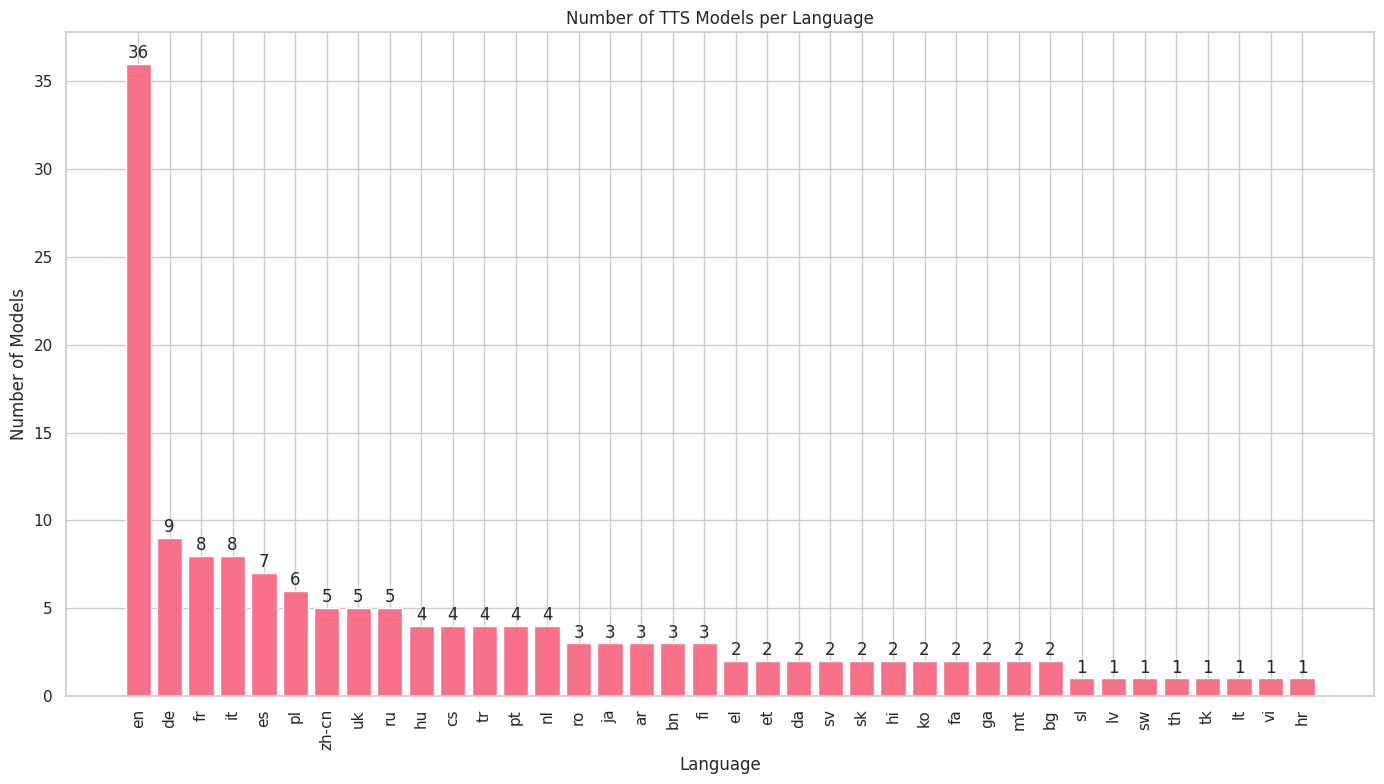

In [3]:
def plot_models_per_language(language_models):
    models_count = {lang: len(models) for lang, models in language_models.items()}
    models_df = pd.DataFrame(list(models_count.items()), columns=['Language', 'Number of Models'])
    models_df = models_df.sort_values('Number of Models', ascending=False)
    plt.figure(figsize=(14, 8))
    bars = plt.bar(models_df['Language'], models_df['Number of Models'])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1, f'{height:.0f}', ha='center', va='bottom')
    plt.title('Number of TTS Models per Language')
    plt.xlabel('Language')
    plt.ylabel('Number of Models')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_models_per_language(language_models)

## 3. Audio Analysis

In [4]:

def analyze_audio_samples(languages, language_models, num_samples=3):
    audio_data = []
    for lang in tqdm(random.sample(languages, min(5, len(languages))), desc="Analyzing languages"):
        if language_models[lang]:
            model = random.choice(language_models[lang])
            model_path = os.path.join(DATASET_PATH, lang, model)
            wav_files = glob.glob(os.path.join(model_path, "*.wav"))
            if wav_files:
                for wav_file in random.sample(wav_files, min(num_samples, len(wav_files))):
                    try:
                        y, sr = librosa.load(wav_file, sr=None)
                        duration = librosa.get_duration(y=y, sr=sr)
                        rms = np.sqrt(np.mean(y**2))
                        audio_data.append({
                            'Language': lang,
                            'Model': model,
                            'Filename': os.path.basename(wav_file),
                            'Duration': duration,
                            'Sample Rate': sr,
                            'RMS': rms,
                            'Min': np.min(y),
                            'Max': np.max(y),
                            'Path': wav_file
                        })
                    except Exception as e:
                        print(f"Error processing {wav_file}: {str(e)}")
    audio_df = pd.DataFrame(audio_data)
    return audio_df

audio_df = analyze_audio_samples(languages, language_models)
audio_df


Analyzing languages:   0%|          | 0/5 [00:00<?, ?it/s]

,Language,Model,Filename,Duration,Sample Rate,RMS,Min,Max,Path
0,en,tts_models_en_ljspeech_neural_hmm,emerald_city_of_oz_19_f000076.wav,13.341315,22050,0.074530,-0.563171,0.729218,/home/victor.moreno/dl-29_backup/spoof/dataset...
1,en,tts_models_en_ljspeech_neural_hmm,northandsouth_05_f000219.wav,5.097506,22050,0.076363,-0.475494,0.687531,/home/victor.moreno/dl-29_backup/spoof/dataset...
2,en,tts_models_en_ljspeech_neural_hmm,midnight_passenger_12_f000183.wav,8.568889,22050,0.073305,-0.637115,0.817169,/home/victor.moreno/dl-29_backup/spoof/dataset...
3,bg,tts_models_multilingual_multi-dataset_bark,jane_eyre_25_f000188.wav,28.953333,22050,0.165705,-0.831207,0.999969,/home/victor.moreno/dl-29_backup/spoof/dataset...
4,bg,tts_models_multilingual_multi-dataset_bark,poisoned_pen_06_f000043.wav,13.549977,22050,0.030438,-0.328094,0.303497,/home/victor.moreno/dl-29_backup/spoof/dataset...
5,bg,tts_models_multilingual_multi-dataset_bark,midnight_passenger_04_f000245.wav,14.216644,22050,0.071936,-0.726044,0.408508,/home/victor.moreno/dl-29_backup/spoof/dataset...
6,it,tts_models_it_mai_male_glow-tts,novelle01_17_pirandello_f000027.wav,6.592971,22050,0.344284,-1.000000,0.999969,/home/victor.moreno/dl-29_backup/spoof/dataset...
7,it,tts_models_it_mai_male_glow-tts,la_contessa_di_karolystria_6_ghislanzoni_f0000...,8.576961,22050,0.343810,-1.000000,0.999969,/home/victor.moreno/dl-29_backup/spoof/dataset...
8,it,tts_models_it_mai_male_glow-tts,novelle02_07_pirandello_f000235.wav,2.592971,22050,0.303396,-1.000000,0.999969,/home/victor.moreno/dl-29_backup/spoof/dataset...
9,hr,tts_models_hr_cv_vits,northandsouth_39_f000091.wav,4.772426,22050,0.069760,-0.377228,0.254211,/home/victor.moreno/dl-29_backup/spoof/dataset...


In [5]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def process_wav_file(wav_file):
    try:
        lang = wav_file['lang']
        path = wav_file['path']
        y, sr = librosa.load(path, sr=None)
        return {
            'Language': lang,
            'Filename': os.path.basename(path),
            'Duration': librosa.get_duration(y=y, sr=sr),
            'Sample Rate': sr,
            'RMS': np.sqrt(np.mean(y**2)),
            'Min': np.min(y),
            'Max': np.max(y),
            'Path': path
        }
    except Exception as e:
        print(f"Error processing {path}: {str(e)}")
        return None

# Prepare all files
all_wavs = []
for lang in languages:
    for model in language_models[lang]:
        model_path = os.path.join(DATASET_PATH, lang, model)
        wav_files = glob.glob(os.path.join(model_path, "*.wav"))
        all_wavs.extend({'lang': lang, 'path': f} for f in wav_files)

# Parallel processing
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_wav_file, wav) for wav in all_wavs]
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result:
            results.append(result)

df_all_audio_stats = pd.DataFrame(results)
df_all_audio_stats.head()


  0%|          | 0/154000 [00:00<?, ?it/s]

,Language,Filename,Duration,Sample Rate,RMS,Min,Max,Path
0,ar,silent_bullet_06_f000212.wav,15.317959,22050,0.046602,-0.440247,0.539551,/home/victor.moreno/dl-29_backup/spoof/dataset...
1,ar,midnight_passenger_05_f000114.wav,12.021995,22050,0.046360,-0.434875,0.439484,/home/victor.moreno/dl-29_backup/spoof/dataset...
2,ar,rinkitink_baum_10_64kb_f000040.wav,14.667302,22050,0.057453,-0.612549,0.705688,/home/victor.moreno/dl-29_backup/spoof/dataset...
3,ar,wives_and_daughters_17_f000201.wav,8.907302,22050,0.067877,-0.678467,0.661133,/home/victor.moreno/dl-29_backup/spoof/dataset...
4,ar,poisoned_pen_06_f000297.wav,6.539320,22050,0.049672,-0.424011,0.488495,/home/victor.moreno/dl-29_backup/spoof/dataset...


In [6]:
df_all_audio_stats.describe()


,Duration,Sample Rate,RMS,Min,Max
count,154000.000000,154000.0,154000.000000,154000.000000,154000.000000
mean,8.835391,22050.0,0.086842,-0.574900,0.584767
std,5.885212,0.0,0.052817,0.247142,0.245244
min,0.223991,22050.0,0.000912,-1.000000,0.015839
25%,5.212914,22050.0,0.050108,-0.783272,0.377655
50%,7.976780,22050.0,0.074077,-0.554047,0.560120
75%,11.309977,22050.0,0.115496,-0.355835,0.790344
max,257.639184,22050.0,0.835761,-0.017609,0.999969


In [7]:
def collect_audio_stats():
    """Collect audio statistics for all WAV files in the dataset."""
    audio_stats = []
    
    for lang in tqdm(languages, desc="Processing languages"):
        for model in language_models[lang]:
            model_path = os.path.join(DATASET_PATH, lang, model)
            wav_files = glob.glob(os.path.join(model_path, "*.wav"))
            
            for wav_file in wav_files:
                try:
                    y, sr = librosa.load(wav_file, sr=None)
                    stats = {
                        'Language': lang,
                        'Filename': os.path.basename(wav_file),
                        'Duration': librosa.get_duration(y=y, sr=sr),
                        'Sample Rate': sr,
                        'RMS': np.sqrt(np.mean(y**2)),
                        'Min': np.min(y),
                        'Max': np.max(y),
                        'Path': wav_file
                    }
                    audio_stats.append(stats)
                except Exception as e:
                    print(f"Error processing {wav_file}: {str(e)}")
    
    df_audio_stats = pd.DataFrame(audio_stats)
    return df_audio_stats

# Run the function to collect data
df_all_audio_stats = collect_audio_stats()

# Display the first few rows
df_all_audio_stats.head()


Processing languages:   0%|          | 0/38 [00:00<?, ?it/s]

,Language,Filename,Duration,Sample Rate,RMS,Min,Max,Path
0,ar,jane_eyre_36_f000097.wav,8.353333,22050,0.058502,-0.501068,0.536591,/home/victor.moreno/dl-29_backup/spoof/dataset...
1,ar,poisoned_pen_10_f000218.wav,19.766667,22050,0.047630,-0.265167,0.324585,/home/victor.moreno/dl-29_backup/spoof/dataset...
2,ar,jane_eyre_14_f000025.wav,3.797959,22050,0.109347,-0.595428,0.743011,/home/victor.moreno/dl-29_backup/spoof/dataset...
3,ar,midnight_passenger_02_f000091.wav,10.763311,22050,0.066911,-0.569916,0.641724,/home/victor.moreno/dl-29_backup/spoof/dataset...
4,ar,emerald_city_of_oz_09_f000007.wav,8.725986,22050,0.053206,-0.423889,0.402771,/home/victor.moreno/dl-29_backup/spoof/dataset...


Language: hr
Model: tts_models_hr_cv_vits
Filename: northandsouth_39_f000091.wav
Duration: 4.77 seconds
Sample Rate: 22050 Hz


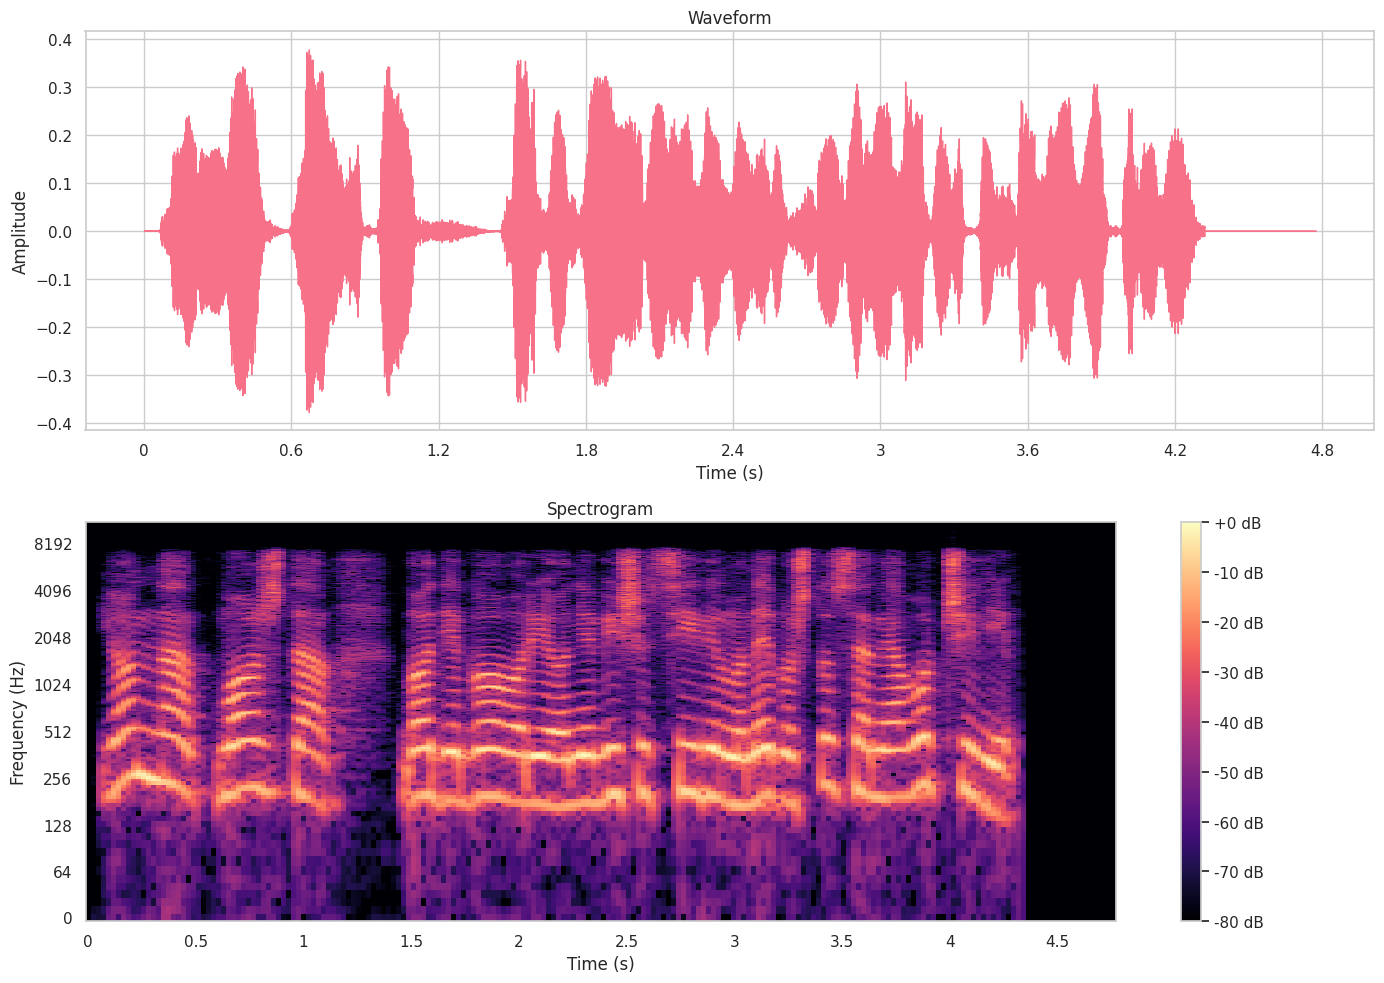

Audio sample:


In [8]:

def plot_audio_analysis(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set_title('Waveform')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('Amplitude')
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, ax=ax[1])
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
    ax[1].set_title('Spectrogram')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()
    print("Audio sample:")
    display(Audio(y, rate=sr))

if not audio_df.empty:
    random_sample = audio_df.sample(1).iloc[0]
    print(f"Language: {random_sample['Language']}")
    print(f"Model: {random_sample['Model']}")
    print(f"Filename: {random_sample['Filename']}")
    print(f"Duration: {random_sample['Duration']:.2f} seconds")
    print(f"Sample Rate: {random_sample['Sample Rate']} Hz")
    plot_audio_analysis(random_sample['Path'])
